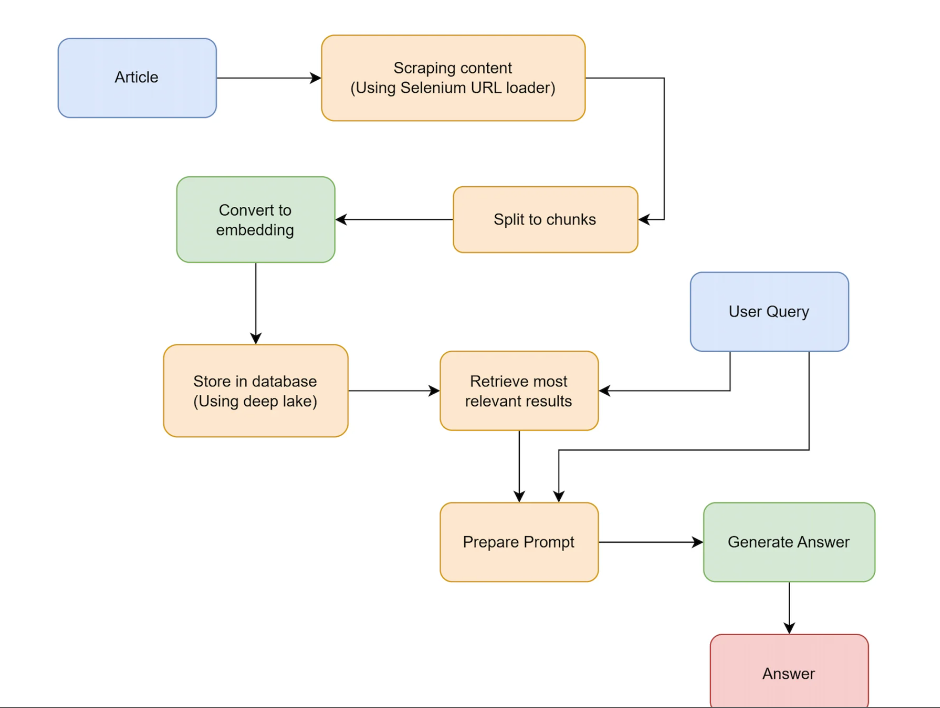

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.environ.get('OPENAI_API_KEY')
os.environ['ACTIVELOOP_TOKEN'] = os.environ.get('ACTIVELOOP_TOKEN')

In [13]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import DeepLake
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAI
from langchain.document_loaders import SeleniumURLLoader
from langchain import PromptTemplate

In [3]:
# we'll use information from the following articles
urls = ['https://beebom.com/what-is-nft-explained/',
        'https://beebom.com/how-delete-spotify-account/',
        'https://beebom.com/how-download-gif-twitter/',
        'https://beebom.com/how-use-chatgpt-linux-terminal/',
        'https://beebom.com/how-delete-spotify-account/',
        'https://beebom.com/how-save-instagram-story-with-music/',
        'https://beebom.com/how-install-pip-windows/',
        'https://beebom.com/how-check-disk-usage-linux/']

In [4]:
# use the selenium scraper to load the documents
loader = SeleniumURLLoader(urls=urls)
docs_not_splitted = loader.load()

# we split the documents into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(docs_not_splitted)

Created a chunk of size 1226, which is longer than the specified 1000


In [5]:
# Before executing the following code, make sure to have
# your OpenAI key saved in the “OPENAI_API_KEY” environment variable.
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

In [7]:
# create Deep Lake dataset
# TODO: use your organization id here. (by default, org id is your username)
my_activeloop_org_id = "e2tovar"
my_activeloop_dataset_name = "langchain_course_chat"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"
db = DeepLake(dataset_path=dataset_path, embedding=embeddings)

db.add_documents(docs)

Your Deep Lake dataset has been successfully created!


Creating 150 embeddings in 1 batches of size 150:: 100%|██████████| 1/1 [00:18<00:00, 18.12s/it]

Dataset(path='hub://e2tovar/langchain_course_chat', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (150, 1)      str     None   
 metadata     json      (150, 1)      str     None   
 embedding  embedding  (150, 1536)  float32   None   
    id        text      (150, 1)      str     None   


['d50d9553-d5bd-11ee-a81c-482ae342e600',
 'd50d9554-d5bd-11ee-be70-482ae342e600',
 'd50d9555-d5bd-11ee-a7c2-482ae342e600',
 'd50d9556-d5bd-11ee-9f94-482ae342e600',
 'd50d9557-d5bd-11ee-a710-482ae342e600',
 'd50d9558-d5bd-11ee-8214-482ae342e600',
 'd50d9559-d5bd-11ee-bd5f-482ae342e600',
 'd50d955a-d5bd-11ee-b2c2-482ae342e600',
 'd50d955b-d5bd-11ee-9b86-482ae342e600',
 'd50d955c-d5bd-11ee-bbd9-482ae342e600',
 'd50d955d-d5bd-11ee-98a4-482ae342e600',
 'd50d955e-d5bd-11ee-be65-482ae342e600',
 'd50d955f-d5bd-11ee-9ddb-482ae342e600',
 'd50d9560-d5bd-11ee-917b-482ae342e600',
 'd50d9561-d5bd-11ee-a8a3-482ae342e600',
 'd50d9562-d5bd-11ee-a122-482ae342e600',
 'd50d9563-d5bd-11ee-8264-482ae342e600',
 'd50d9564-d5bd-11ee-b56b-482ae342e600',
 'd50d9565-d5bd-11ee-aee0-482ae342e600',
 'd50d9566-d5bd-11ee-acc1-482ae342e600',
 'd50d9567-d5bd-11ee-92dc-482ae342e600',
 'd50d9568-d5bd-11ee-a605-482ae342e600',
 'd50d9569-d5bd-11ee-844f-482ae342e600',
 'd50d956a-d5bd-11ee-a4f4-482ae342e600',
 'd50d956b-d5bd-

To retrieve the most similar chunks to a given query, we can use the similarity_search method of the Deep Lake vector store:

In [8]:
# let's see the top relevant documents to a specific query
query = "how to check disk usage in linux?"
docs = db.similarity_search(query)
print(docs[0].page_content)

Check Disk Usage Using Gnome Disk Tool

Check Disk Usage Using Disk Usage Analyzer Tool

Cleanup Disk using Disk Usage Analyzer

Check Disk Space Using the df Command

In Linux, there are many commands to check disk usage, the most common being the df command. The df stands for “Disk Filesystem” in the command, which is a handy way to check the current disk usage and the available disk space in Linux. The syntax for the df command in Linux is as follows:

df <options> <file_system>

The options to use with the df command are:

Options Description -a Show information about all file systems including pseudo, duplicate and inaccessible file systems -h Display the sizes in human-readable format i.e in powers of 1024 -t Display the disk usage of only the file system of a particular type -x Display the disk usage excluding a particular file type

Display Disk Usage in Human Readable Format


## Prompt for GPT-3 using the suggested strategies

In [11]:
# let's write a prompt for a customer support chatbot that
# answer questions using information extracted from our db
template = """You are an exceptional customer support chatbot that gently answer questions.

You know the following context information.

{chunks_formatted}

Answer to the following question from a customer. Use only information from the previous context information. Do not invent stuff.

Question: {query}

Answer:"""

prompt = PromptTemplate(
    input_variables=["chunks_formatted", "query"],
    template=template,
)

To generate a response, we first retrieve the top-k (e.g., top-3) chunks most similar to the user query, format the prompt, and send the formatted prompt to the GPT3 model with a temperature of 0.

In [14]:
# the full pipeline

# user question
query = "How to check disk usage in linux?"

# retrieve relevant chunks
docs = db.similarity_search(query)
retrieved_chunks = [doc.page_content for doc in docs]

# format the prompt
chunks_formatted = "\n\n".join(retrieved_chunks)
prompt_formatted = prompt.format(chunks_formatted=chunks_formatted, query=query)

# generate answer
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)
answer = llm.invoke(prompt_formatted)
print(answer)

 There are several ways to check disk usage in Linux. One of the most common methods is by using the df command. You can also use GUI tools like the Gnome Disk Tool or the Disk Usage Analyzer Tool to easily monitor disk usage. These tools provide a visual representation of the disk occupancy and allow you to delete unnecessary files or folders to free up space.
